This code is to display the experimental results in the paper "Gradient Normalization Makes Heterogeneous Distributed
Learning as Easy as Homogenous Distributed Learning" by Tao Sun.

In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

## Notations

n : the number of nodes

m : the number of local data samples within each node

d : dimension of the feature vectors

i : node index

## logistic regression utilities

Consider the logistic regression problem: 

$\min\ F(w) = \frac{1}{n}\sum_{i=1}^n f_i(w) + \rho r(w)$ where $f_i(w) = \frac{1}{m}\sum_{l=1}^m \ln(1 + \exp(-y_{i,l} x_{i,l}^T w))$, and $r(w) = \sum_{j=1}^d \frac{w(j)^2}{1 + w(j)^2}$ is a non-convex regularization term.

Subscript $i$ indicates the node index, and $l$ indicates the local data index. Data samples $\{x_{i,l}, y_{i,l}\}_{l=1}^m$ are kept locally in node $i$.

The gradient can be calculated as follow:

The gradient of $\frac{1}{n}\sum_{i=1}^n f_i(w)$ is: $\nabla \frac{1}{n}\sum_{i=1}^n f_i(w) = \frac{1}{nm}\sum_{i=1}^n\sum_{l=1}^m \beta_{i,l} y_{i,l} x_{i,l}$ 

where $\beta_{i,l} = \frac{\exp(-y_{i,l} x_{i,l}^T w)}{1 + \exp(-y_{i,l} x_{i,l}^T w)}$.

The gradient of $r(w)$ is: $\nabla r(w) = \sum_{i=1}^d \frac{2 w(j)}{(1+w(j)^2)^2}$

In [ ]:
# Generate full gradient of the logistic regression problem

def lr_full_grad(X, y, w, rho):  
    
    _, M = X.shape
    
    prob = np.exp(- y * X.dot(w))
    alpha = prob / (1 + prob)
    
    r_grad = 2*rho*np.sum(w/((1+w*w)*(1+w*w)))
    
    grad = r_grad - np.mean(alpha*y*X, axis = 0).reshape(M, 1)
    
    return grad

In [ ]:
# Generate full local gradient at W
# G has dimensions (n, M), which stacks each local gradient one by one

def lr_full_grad_dist(X, y, W, rho):
    
    total_sample_size, M = X.shape
    n = W.shape[0]
    S = total_sample_size//n    
    
    G = np.zeros((n, M))
    
    for i in range(n):
        
        wi = W[i,:].reshape(M, 1)        
        Xi = X[i*S:(i+1)*S, :]
        yi = y[i*S:(i+1)*S].reshape(S, 1)
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        grad = r_grad - np.mean(beta*yi*Xi, axis = 0).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

In [ ]:
# Generate stochastic local gradient at W
# G has dimensions (n, M), which stacks each local gradient one by one

def lr_sto_grad_dist(X, y, W, rho):  
    
    total_sample_size, M = X.shape
    n = W.shape[0]
    S = total_sample_size//n 
    
    G = np.zeros((n, M))
    s = np.random.randint(1,S)
    for i in range(n):
        
        wi = W[i,:].reshape(M, 1)        
        Xi = X[[i*S + s], :]
        yi = y[i*S + s]
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        grad = r_grad - (beta*yi*Xi).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

In [ ]:
# Generate mini-batch stochastic local gradient at W
# G has dimensions (n, M), which stacks each local gradient one by one
# n_1 is the batch size

def lr_part_sto_grad_dist(X,y,W,rho): 
    
    total_sample_size, M = X.shape
    n = W.shape[0]
    S = total_sample_size//n    
    n_1 = 20    
    G = np.zeros((n, M))
    for i in range(n):

        a = np.random.choice(S,n_1,replace=False) + i*S
        wi = W[i,:].reshape(M, 1) 
        Xi = X[a, :]
        yi = y[a].reshape(n_1,1)
        
        prob = np.exp(- yi * Xi.dot(wi))
        beta = prob / (1 + prob)

        r_grad = 2*rho*np.sum(wi/((1+wi*wi)*(1+wi*wi)))
        grad = r_grad - np.mean((beta*yi*Xi),axis = 0).reshape(M, 1)
        G[i,:] = grad.T
    
    return G

### Compressor

In [ ]:
class Compressor():

    def __init__(self, unbiased):

        self.unbiased = unbiased
        self.contractive = not self.unbiased

    def compress(self, X):

        pass

class TopK(Compressor):

    def __init__(self, K):

        super().__init__(False)
        self.K = K

    def compress(self, X):

        X_compressed = np.zeros_like(X)
        idx = np.abs(X).argsort(axis = 1)[:,-self.K:]
        for k in range(X.shape[0]):
            X_compressed[k, idx[k]] = X[k, idx[k]]
        return X_compressed

class RandK(Compressor):

    def __init__(self, K, shared_randomness=True):

        super().__init__(False)
        self.K = K
        self.share = shared_randomness

    def compress(self, X):

        X_compressed = np.zeros_like(X)
        M = X.shape[1]
        if self.share:
            idx = np.random.randint(0,M,self.K)
            X_compressed[:, idx] = X[:, idx]
        else:
            idx = np.random.randint(0,M, (X.shape[0],self.K))
            X_compressed[idx] = X[idx]
        return X_compressed

class uRandK(Compressor):

    def __init__(self, K, shared_randomness=True):

        super().__init__(True)
        self.K = K
        self.share = shared_randomness

    def compress(self, X):

        X_compressed = np.zeros_like(X)
        M = X.shape[1]
        if self.share:
            # idx = np.random.randint(0,M,self.K)
            idx = np.random.choice(M, self.K, replace=False)
            X_compressed[:, idx] = X[:, idx]
        else:
            # idx = np.random.randint(0,M, (X.shape[0],self.K))
            for k in range(X.shape[0]):
                idx = np.random.choice(M, self.K, replace=False)
                X_compressed[k, idx] = X[k, idx]
            # X_compressed[idx] = X[idx]
        return X_compressed / self.K * M

    def cal_omega(self, M):

        return M / self.K - 1 

class FCC(Compressor):

    def __init__(self, compressor, R):

        super().__init__(compressor.unbiased)
        self.compressor = compressor
        self.R = R
    
    def compress(self, X):

        V = np.zeros_like(X)

        if self.unbiased:

            omega = self.compressor.cal_omega(X.shape[1])
            for r in range(self.R):
                V += self.compressor.compress(X - V) / (1 + omega)
            return V / (1 - (omega / (1 + omega))**self.R)
        
        else:

            for r in range(self.R):
                V += self.compressor.compress(X - V)
            return V
    
    def cal_omega(self, M):

        assert self.unbiased
        omega = self.compressor.cal_omega(M)
        return omega * (omega / (1 + omega))**self.R
    
class NaturalCompression(Compressor):
     
    def __init__(self):
        super().__init__(True)

    def compress(self, X):
        # get mantissa of all entries of numpy array X
        mantissa, exponent = np.frexp(X)
        # get the sign of all entries of numpy array X
        sign = np.sign(X)
        unsigned_mantissa = mantissa * sign
        # calculate the possibility of the Bernoulli experiment
        p = (mantissa * np.sign(X) * 2 - 1).clip(min=0)
        # generate random exponent shift
        shift = np.random.binomial(n=1, p=p, size=X.shape)
        
        return sign * 2.0**(exponent + shift - 1)
        
class RandomQuantization(Compressor):

    def __init__(self, s):
        super().__init__(True)
        self.s = s
        self.llist = [1] + [3] * 2 + [6] * 4 + [7] * 8 + [11] * 16 + [12] * 32 # shifted Elias code
        self.llist = np.array(self.llist)
        self.name = 'RandomQuantization'

    def compress(self, X):
        # calculate the l2 norm of each row
        norm_0 = np.linalg.norm(X, axis=1, keepdims=True)
        norm = norm_0 + (norm_0 == 0) # avoid dividing by zero
        # keep the signs
        signs = np.sign(X)
        X = np.abs(X)
        # calculate the normalized X
        X /= norm
        # print('normalized X:', X)
        # scale X by s
        X *= self.s
        # compute lower bound
        lb = np.floor(X)
        # print('lb:', lb)
        # compute possibility of Bernoulli experiment
        p = X - lb
        # print('p:', p)
        # generate random matrix
        random_matrix = np.random.binomial(n=1, p=p, size=X.shape)
        # compute quantized matrix
        quantized_matrix = lb + random_matrix
        # print('quantized code length:', self.llist[quantized_matrix.astype(int)])
        # print('quantized matrix: ', quantized_matrix)
        # compute the compressed matrix
        compressed_matrix = quantized_matrix * norm_0
        return compressed_matrix * signs / self.s, self.llist[quantized_matrix.astype(int)].sum(axis=1).mean(axis=0) + 64

### Normalized SGD with MSC (decaying learning rate)

In [ ]:
def dist_normalized_sgd_fcc(X,y,n,theta,gamma,u,compressor,noise,T,epochs):
    
    M = X.shape[1]
    m_c = np.zeros((n,M))
    G = np.zeros((n,M))
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    w0 = np.zeros((1,M))
    learning_rate = gamma

    for e in range(epochs):
        W = np.zeros((n,M))
        m = np.zeros((n,M))
        w = w0
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)
        
        for t in range(T):
            if t>1 and t %2000==0:
                learning_rate = learning_rate/2
            for i in range(n):
                W[i] = w
            G = lr_part_sto_grad_dist(X,y,W,rho) + noise * np.random.randn(n, M)
            m = theta * m + (1-theta) * G
            m_c = FCC(compressor,u).compress(m)
            w = w - learning_rate * np.sum(m_c,axis=0) / (np.linalg.norm(np.sum(m_c,axis=0)))
            g = lr_full_grad(X, y, w.T, rho)
            
            grad_norm[t+1] = np.linalg.norm(g, 2)
        grad_norm_mean += grad_norm
    grad_norm_mean = grad_norm_mean / epochs
    
    return grad_norm_mean

### MEM SGD (decaying laerning rate)

In [ ]:
def mem_sgd_fcc(X,y,n,compressor,noise,gamma,u,T,epochs):
    
    M = X.shape[1]
    G = np.zeros((n,M))
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    w0 = np.zeros((1,M))
    learning_rate = gamma

    for e in range(epochs):
        W = np.zeros((n,M))
        w = w0
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)
        error = np.zeros((n,M))
        
        for t in range(T):
            if t>1 and t %2000==0:
                learning_rate = learning_rate/2
            G = lr_part_sto_grad_dist(X,y,W,rho) + noise * np.random.randn(n, M)
            G_c = FCC(compressor,u).compress(learning_rate * G + error)
            Psi = W - G_c
            W = np.ones((n, n)).dot(Psi) / n
            error = error + learning_rate * G - G_c
            w = np.mean(W,axis=0).reshape(1,M)
            g = lr_full_grad(X, y, w.T, rho)
            grad_norm[t+1] = np.linalg.norm(g, 2)
        grad_norm_mean +=grad_norm
    grad_norm_mean = grad_norm_mean/epochs
    
    return grad_norm_mean

### QSGD (decaying learning rate)

In [ ]:
def qsgd(X,y,n,gamma,noise,compressor,u,T,epochs):
    
    M = X.shape[1]
    G = np.zeros((n,M))
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    w0 = np.zeros((1,M))
    learning_rate = gamma

    for e in range(epochs):
        W = np.zeros((n,M))
        w = w0
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)
        
        for t in range(T):
            if t>1 and t %2000==0:
                learning_rate = learning_rate/2
            G = lr_part_sto_grad_dist(X,y,W,rho) + noise * np.random.randn(n, M)
            G_q = FCC(compressor,u).compress(G)
            Psi = W - learning_rate * G_q
            W = np.ones((n, n)).dot(Psi) / n
            w = np.mean(W, axis=0).reshape(1, M)
            g = lr_full_grad(X, y, w.T, rho)
            grad_norm[t+1] = np.linalg.norm(g, 2)
        grad_norm_mean += grad_norm
    grad_norm_mean = grad_norm_mean/epochs
    
    return grad_norm_mean

### EF21 SGD (decaying learning rate)

In [ ]:
def ef21_sgd_fcc(X,y,n,gamma,noise,compressor,u,T,epochs):
    
    M = X.shape[1]
    grad_norm = np.zeros((T+1,1))
    grad_norm_mean = np.zeros((T+1,1))
    w0 = np.zeros((1,M))
    learning_rate = gamma

    for e in range(epochs):
        
        G_old = np.zeros((n,M))
        g_old = np.sum(G_old, axis = 0)/n
        W = np.zeros((n,M))
        w = w0
        g = lr_full_grad(X,y,w0.T,rho)
        grad_norm[0] = np.linalg.norm(g,2)
        
        for t in range(T):
            if t>1 and t %2000==0:
                learning_rate = learning_rate/2
            w = w - learning_rate * g_old
            for i in range(n):
                W[i] = w
            G_new = lr_part_sto_grad_dist(X,y,W,rho) + noise * np.random.randn(n, M)
            G_q = FCC(compressor,u).compress(G_new - G_old)
            G_old = G_old + G_q
            g_old = np.sum(G_old, axis = 0) / n
            
            w = np.mean(W, axis=0).reshape(1, M)
            g = lr_full_grad(X, y, w.T, rho)
            grad_norm[t+1] = np.linalg.norm(g, 2)
        grad_norm_mean += grad_norm
    grad_norm_mean = grad_norm_mean / epochs
    
    
    return grad_norm_mean

### Generate non-iid data on MNIST dataset

In [ ]:
# Generate base data from 10 classes according to the label of MNIST (each label corresponds to a class)
# because the amount of data from each class is different, so we need to use d to store the data size of each class.

def lr_generate_base_data_mnist(): 
 
    (X_train, y_train), _ = mnist.load_data()

    X0 = np.zeros((60000, 28, 28))
    y0 = np.zeros(60000).astype(int)
    l = 0
    d = np.zeros(10).astype(int)
    for i in range(10):
        A = np.argwhere(y_train == i).flatten()   # the dimension (28,28) will be flattened to 784
        X0[l:l+len(A)] = X_train[A]
        
        if i <= 4:
            y0[l:l+len(A)] = 1
        else:
            y0[l:l+len(A)] = 0
        
        #y0[l:l+len(A)]=y_train[A]
        l += len(A)
        d[i] = len(A)
    
    return X0,y0,d

In [ ]:
# Generate non-iid data from 10 classes 

def lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha,N,d):

    M = X0[0].flatten().shape[0]
    S = total_sample_size//n
    X = np.zeros((total_sample_size,M))
    y = np.zeros((total_sample_size,1))
    q = np.random.dirichlet(alpha*p0,n)   
    for i in range(n):
        class_labels = np.random.choice(N,size = S,p=q[i])
        Xi = np.zeros((S,M))
        yi = np.zeros((S,1))

        # sample non-iid data from X0,y0 which store the different N classes data
        for k in range(S):
            c = class_labels[k]
            s = np.random.choice(d[c])
            begin = np.sum(d[0:c])
            Xi[k] = X0[begin+s].flatten()
            yi[k] = y0[begin+s]
            
        X[i*S:(i+1)*S,:] = Xi
        y[i*S:(i+1)*S] = yi
    y = 2*y-1
    return X,y

In [ ]:
np.random.seed(2023)
n, M = 100, 784 # n is the amount of worker, M is the local data dimension
total_sample_size = n * 600 # 600 is the local data size 
rho = 0.001
N = 10 

X0,y0,d = lr_generate_base_data_mnist()


alpha1,alpha2,alpha3= 10, 1, 0.1
L = 1
var = np.var(X0,axis=0)
sigma2 = 100
p0 = np.ones(N)/N
X1,y1 = lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha1,N,d)
X3,y3 = lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha3,N,d)
X2,y2 = lr_generate_noniid_data_mnist(total_sample_size,X0,y0,n,p0,alpha2,N,d)

### Results on MNIST dataset

In [ ]:
gamma1, T, epochs = 0.000015, 4000, 1
u1 = 1
u2 = 8
s = 2
noise1 = 0.05
theta = 0.9#np.random.uniform(0.15,0.35)
gamma = 0.000001#np.random.uniform(0.002,0.01)
w0 = np.zeros((1,M))
compressor1 = TopK(50)

qsgd1 = qsgd(X1,y1,n,gamma,noise1,compressor1,u1,T,epochs)
qsgd2 = qsgd(X2,y2,n,gamma,noise1,compressor1,u1,T,epochs)
qsgd3 = qsgd(X3,y3,n,gamma,noise1,compressor1,u1,T,epochs)
normalized_sgd_fcc1 = dist_normalized_sgd_fcc(X1,y1,n,theta,gamma1,u2,compressor1,noise1,T,epochs)
normalized_sgd_fcc2 = dist_normalized_sgd_fcc(X2,y2,n,theta,gamma1,u2,compressor1,noise1,T,epochs)
normalized_sgd_fcc3 = dist_normalized_sgd_fcc(X3,y3,n,theta,gamma1,u2,compressor1,noise1,T,epochs)
x_arr = np.arange(0, normalized_sgd_fcc3.shape[0], 1)

In [ ]:
T, epochs = 4000, 1
u1 = 8
noise1 = 0.05
theta = 0.2#np.random.uniform(0.15,0.35)
gamma = 0.000002#np.random.uniform(0.002,0.01)
mem_sgd1 = mem_sgd_fcc(X1,y1,n,compressor1,noise1,gamma,u1,T,epochs)
mem_sgd2 = mem_sgd_fcc(X2,y2,n,compressor1,noise1,gamma,u1,T,epochs)
mem_sgd3 = mem_sgd_fcc(X3,y3,n,compressor1,noise1,gamma,u1,T,epochs)
ef21_sgd1 = ef21_sgd_fcc(X1,y1,n,gamma,noise1,compressor1,u1,T,epochs)
ef21_sgd2 = ef21_sgd_fcc(X2,y2,n,gamma,noise1,compressor1,u1,T,epochs)
ef21_sgd3 = ef21_sgd_fcc(X3,y3,n,gamma,noise1,compressor1,u1,T,epochs)

In [ ]:
def min(grad_norm_mean):
    T = grad_norm_mean.shape[0]
    grad_norm_min = np.zeors(1+T)
    for i in range(T):
        grad_norm_min[i] = np.min(grad_norm_mean[0:i+1])
    return grad_norm_min

min_normalized_sgd_fcc1 = min(normalized_sgd_fcc1)
min_normalized_sgd_fcc2 = min(normalized_sgd_fcc2)
min_normalized_sgd_fcc3 = min(normalized_sgd_fcc3)

min_mem_sgd1 = min(mem_sgd1)
min_mem_sgd2 = min(mem_sgd2)
min_mem_sgd3 = min(mem_sgd3)

min_qsgd1 = min(qsgd1)
min_qsgd2 = min(qsgd2)
min_qsgd3 = min(qsgd3)

min_ef21_sgd1 = min(ef21_sgd1)
min_ef21_sgd2 = min(ef21_sgd2)
min_ef21_sgd3 = min(ef21_sgd3)


In [42]:
a = np.max(np.concatenate(min_normalized_sgd_fcc1,min_normalized_sgd_fcc2,min_normalized_sgd_fcc3,min_mem_sgd1,min_mem_sgd2,min_mem_sgd3,min_qsgd1,min_qsgd2,min_qsgd3,min_ef21_sgd1,min_ef21_sgd2,min_ef21_sgd3))

min_normalized_sgd_fcc1 = min_normalized_sgd_fcc1/a
min_normalized_sgd_fcc2 = min_normalized_sgd_fcc2/a
min_normalized_sgd_fcc3 = min_normalized_sgd_fcc3/a
min_mem_sgd1 = min_mem_sgd1/a
min_mem_sgd2 = min_mem_sgd2/a
min_mem_sgd3 = min_mem_sgd3/a
min_qsgd1 = min_qsgd1/a
min_qsgd2 = min_qsgd2/a
min_qsgd3 = min_qsgd3/a
min_ef21_sgd1 = min_ef21_sgd1/a
min_ef21_sgd2 = min_ef21_sgd2/a
min_ef21_sgd3 = min_ef21_sgd3/a

Text(0, 0.5, 'gradient norm')

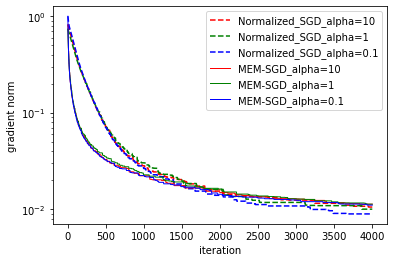

In [49]:
x_arr = np.arange(0, mem_sgd3.shape[0], 1)


plt.semilogy(x_arr, min_normalized_sgd_fcc1[x_arr], linewidth=1.5, color='red',linestyle='dashed')
plt.semilogy(x_arr, min_normalized_sgd_fcc2[x_arr], linewidth=1.5, color='green',linestyle='dashed')
plt.semilogy(x_arr, min_normalized_sgd_fcc3[x_arr], linewidth=1.5, color='blue',linestyle='dashed')
plt.semilogy(x_arr, min_mem_sgd1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, min_mem_sgd2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, min_mem_sgd3[x_arr], linewidth=1.0, color='blue',linestyle='solid')


plt.legend(['Normalized_SGD_alpha=10', 'Normalized_SGD_alpha=1','Normalized_SGD_alpha=0.1','MEM-SGD_alpha=10','MEM-SGD_alpha=1','MEM-SGD_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)


Text(0, 0.5, 'gradient norm')

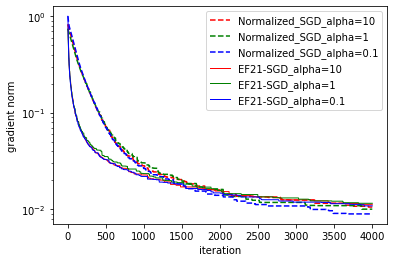

In [50]:
x_arr = np.arange(0, mem_sgd3.shape[0], 1)

plt.semilogy(x_arr, min_normalized_sgd_fcc1[x_arr], linewidth=1.5, color='red',linestyle='dashed')
plt.semilogy(x_arr, min_normalized_sgd_fcc2[x_arr], linewidth=1.5, color='green',linestyle='dashed')
plt.semilogy(x_arr, min_normalized_sgd_fcc3[x_arr], linewidth=1.5, color='blue',linestyle='dashed')
plt.semilogy(x_arr, min_ef21_sgd1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, min_ef21_sgd2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, min_ef21_sgd3[x_arr], linewidth=1.0, color='blue',linestyle='solid')


plt.legend(['Normalized_SGD_alpha=10', 'Normalized_SGD_alpha=1','Normalized_SGD_alpha=0.1','EF21-SGD_alpha=10','EF21-SGD_alpha=1','EF21-SGD_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)

Text(0, 0.5, 'gradient norm')

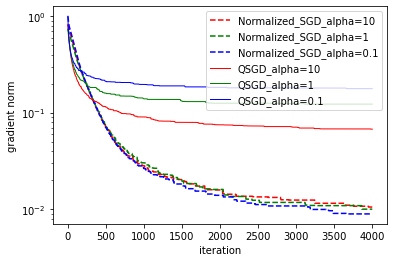

In [51]:
x_arr = np.arange(0, qsgd3.shape[0], 1)

plt.semilogy(x_arr, min_normalized_sgd_fcc1[x_arr], linewidth=1.5, color='red',linestyle='dashed')
plt.semilogy(x_arr, min_normalized_sgd_fcc2[x_arr], linewidth=1.5, color='green',linestyle='dashed')
plt.semilogy(x_arr, min_normalized_sgd_fcc3[x_arr], linewidth=1.5, color='blue',linestyle='dashed')
plt.semilogy(x_arr, min_qsgd1[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, min_qsgd2[x_arr], linewidth=1.0, color='green',linestyle='solid')
plt.semilogy(x_arr, min_qsgd3[x_arr], linewidth=1.0, color='blue',linestyle='solid')

plt.legend(['Normalized_SGD_alpha=10', 'Normalized_SGD_alpha=1','Normalized_SGD_alpha=0.1','QSGD_alpha=10','QSGD_alpha=1','QSGD_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)


### A further comparison among MEM-SGD, EF21-SGD and Normalized SGD with MSC (more iterations)

In [ ]:
gamma1, T, epochs = 0.000015, 16000, 1
u2 = 8
s = 2
noise1 = 0.05
theta = 0.9#np.random.uniform(0.15,0.35)
gamma = 0.000001#np.random.uniform(0.002,0.01)
w0 = np.zeros((1,M))
compressor1 = TopK(50)
normalized_sgd_fcc4 = dist_normalized_sgd_fcc(X3,y3,n,theta,gamma1,u2,compressor1,noise1,T,epochs)

In [ ]:
gamma1, T, epochs = 0.00008, 16000, 1
u1 = 8
s = 2
noise1 = 0.05
gamma = 0.000002#np.random.uniform(0.002,0.01)
mem_sgd4 = mem_sgd_fcc(X3,y3,n,compressor1,noise1,gamma,u1,T,epochs)
ef21_sgd4 = ef21_sgd_fcc(X3,y3,n,gamma,noise1,compressor1,u1,T,epochs)

In [55]:
def min(grad_norm_mean):
    T = grad_norm_mean.shape[0]
    grad_norm_min = np.zeros(1+T)
    for i in range(T):
        grad_norm_min[i] = np.min(grad_norm_mean[0:i+1])
    return grad_norm_min

min_normalized_sgd_fcc4 = min(normalized_sgd_fcc3)

min_mem_sgd4 = min(mem_sgd3)

min_ef21_sgd4 = min(ef21_sgd3)

In [ ]:
a = np.max(np.concatenate(min_ef21_sgd4,min_mem_sgd4,min_normalized_sgd_fcc4))
min_normalized_sgd_fcc4 = min_normalized_sgd_fcc4/a

min_mem_sgd4 = min_mem_sgd4/a

min_ef21_sgd4 = min_ef21_sgd4/a

Text(0, 0.5, 'gradient norm')

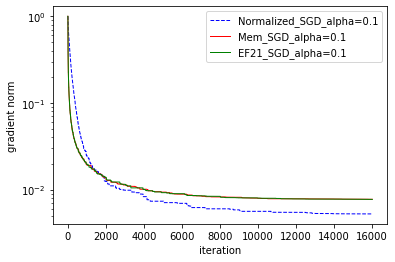

In [59]:
x_arr = np.arange(0, normalized_sgd_fcc4.shape[0], 1)


plt.semilogy(x_arr, min_normalized_sgd_fcc4[x_arr], linewidth=1.0, color='blue',linestyle='dashed')
plt.semilogy(x_arr, min_mem_sgd4[x_arr], linewidth=1.0, color='red',linestyle='solid')
plt.semilogy(x_arr, min_ef21_sgd4[x_arr], linewidth=1.0, color='green',linestyle='solid')


plt.legend(['Normalized_SGD_alpha=0.1', 'Mem_SGD_alpha=0.1','EF21_SGD_alpha=0.1'], fontsize=10)
plt.xlabel('iteration', fontsize = 10)
plt.ylabel('gradient norm', fontsize = 10)
